In [36]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

In [47]:
def analyze_step_response(sp, gy, log_rate, smooth_factor=1, min_input=20):
    """
    Analyze step response between setpoint (desired rate) and gyro (actual rate)
    """
    # Convert inputs to numpy arrays
    sp = np.array(sp)
    gy = np.array(gy)
    
    # Apply smoothing
    smooth_vals = [1, 20, 40, 60]
    window = smooth_vals[smooth_factor-1]
    
    if window > 1:
        if window % 2 == 0:
            window += 1
        gy = savgol_filter(gy, window, 3)
    
    # Find step changes in setpoint
    step_changes = []
    step_sizes = []
    
    i = 0
    while i < len(sp) - 10:
        # Detect start of step
        if abs(sp[i+10] - sp[i]) > min_input:
            step_start = i
            initial_value = sp[i]
            
            # Find where step ends (when setpoint changes again significantly)
            j = i + 10
            while j < len(sp) - 1:
                if abs(sp[j+1] - sp[j]) > min_input:
                    break
                j += 1
                
                # Limit maximum step length
                if j - step_start > 500:
                    break
            
            step_end = min(j, len(sp)-1)
            step_size = abs(sp[step_end] - initial_value)
            
            if step_size > min_input:
                step_changes.append((step_start, step_end))
                step_sizes.append(step_size)
            
            i = step_end
        i += 1
    
    print(f"Found {len(step_changes)} potential step changes")
    
    # Store step responses as lists
    step_responses = []
    setpoint_steps = []
    time_vectors = []
    
    # Analyze each step change
    for (start_idx, end_idx), step_size in zip(step_changes, step_sizes):
        # Extract step response segment
        duration = end_idx - start_idx
        step_sp = sp[start_idx:end_idx+1]  # Include end point
        step_gy = gy[start_idx:end_idx+1]  # Include end point
        
        # Create time vector for this step (matching length)
        t = np.linspace(0, duration/log_rate * 1000, len(step_sp))
        
        # Normalize responses to start at 0
        step_sp = step_sp - step_sp[0]
        step_gy = step_gy - step_gy[0]
        
        # Store the response if it's long enough
        if len(step_sp) > 20:  # Minimum length requirement
            step_responses.append(step_gy)
            setpoint_steps.append(step_sp)
            time_vectors.append(t)
    
    print(f"Extracted {len(step_responses)} valid step responses")
    
    # Get indices of the 3 largest steps based on step size
    if step_responses:
        largest_indices = np.argsort(step_sizes)[-3:]
        
        return ([step_responses[i] for i in largest_indices],
                [setpoint_steps[i] for i in largest_indices],
                [time_vectors[i] for i in largest_indices])
    else:
        return [], [], []

def plot_step_responses(step_responses, setpoint_steps, time_vectors, axis_name, num_responses=3):
    """Plot step responses with analysis"""
    if len(step_responses) == 0:
        plt.figure(figsize=(12, 6))
        plt.text(0.5, 0.5, 'No valid step responses found',
                ha='center', va='center')
        plt.title(f'{axis_name} Axis - No Valid Step Responses')
        plt.show()
        return

    # Limit to requested number of responses
    n = min(len(step_responses), num_responses)
    step_responses = step_responses[:n]
    setpoint_steps = setpoint_steps[:n]
    time_vectors = time_vectors[:n]
    
    # Create subplot for each response
    fig, axes = plt.subplots(n, 1, figsize=(12, 4*n))
    fig.suptitle(f'{axis_name} Axis - Step Responses', fontsize=16)
    
    if n == 1:
        axes = [axes]
    
    colors = ['b', 'g', 'r']
    
    # Plot individual responses
    for i, (resp, sp, t, ax) in enumerate(zip(step_responses, setpoint_steps, time_vectors, axes)):
        # Plot response and setpoint
        ax.plot(t, resp, f'{colors[i]}-', alpha=0.8, label='Actual Response')
        ax.plot(t, sp, f'{colors[i]}--', alpha=0.5, label='Desired Rate')
        
        try:
            final_value = sp[-1]
            rise_10_idx = np.where(resp >= 0.1 * final_value)[0][0]
            rise_90_idx = np.where(resp >= 0.9 * final_value)[0][0]
            rise_time = (rise_90_idx - rise_10_idx) * (t[1] - t[0])
            
            settling_band = 0.02 * abs(final_value)
            settled_indices = np.where(np.abs(resp - final_value) <= settling_band)[0]
            settling_time = t[settled_indices[0]] if len(settled_indices) > 0 else None
            
            overshoot = (np.max(resp) - final_value) / final_value * 100 if final_value != 0 else 0
            
            metrics_text = (f'Step Size: {abs(sp[-1]-sp[0]):.0f} deg/s\n'
                          f'Duration: {t[-1]:.0f}ms\n'
                          f'Rise Time (10-90%): {rise_time:.1f}ms\n')
            if settling_time is not None:
                metrics_text += f'Settling Time (2%): {settling_time:.1f}ms\n'
            metrics_text += f'Overshoot: {overshoot:.1f}%'
            
        except Exception as e:
            print(f"Error calculating metrics for step {i+1}: {str(e)}")
            metrics_text = f'Step Size: {abs(sp[-1]-sp[0]):.0f} deg/s\nError calculating metrics'
        
        ax.text(0.98, 0.98, metrics_text,
                transform=ax.transAxes,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        ax.grid(True)
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Angular Rate (deg/s)')
        ax.set_title(f'Step Response {i+1}')
        ax.legend()
    
    plt.tight_layout()
    plt.show()


Calculated logging rate: 9510.0 Hz

Analyzing Roll axis...
Found 18 potential step changes
Extracted 18 valid step responses
Error calculating metrics for step 1: index 0 is out of bounds for axis 0 with size 0


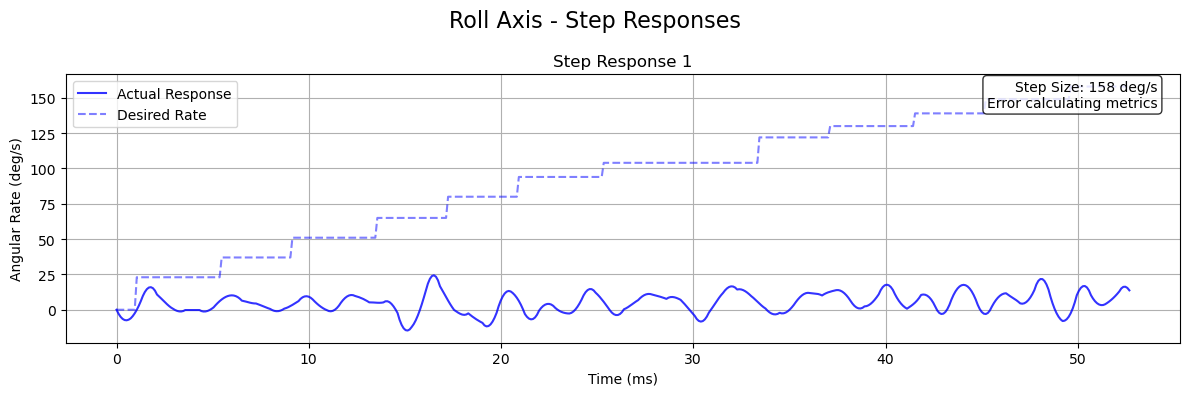


Analyzing Pitch axis...
Found 30 potential step changes
Extracted 30 valid step responses
Error calculating metrics for step 1: index 0 is out of bounds for axis 0 with size 0


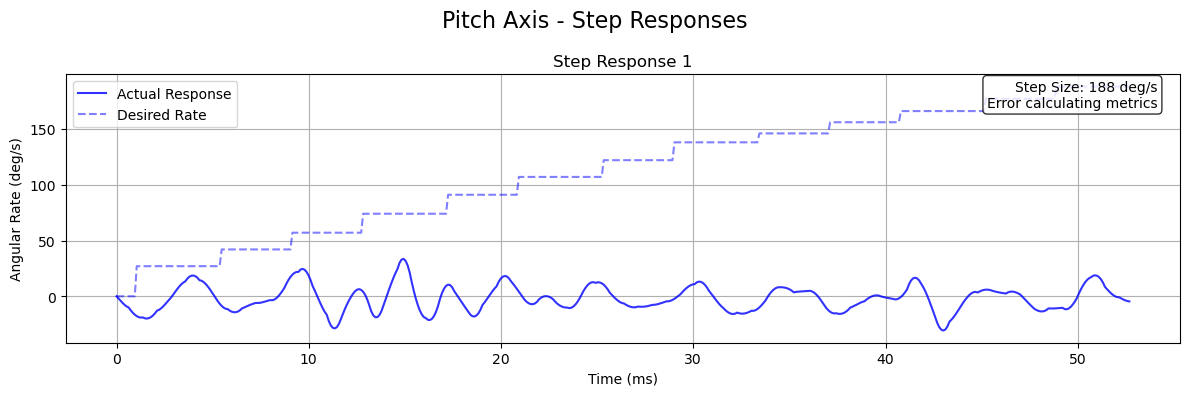


Analyzing Yaw axis...
Found 5 potential step changes
Extracted 5 valid step responses
Error calculating metrics for step 1: index 0 is out of bounds for axis 0 with size 0


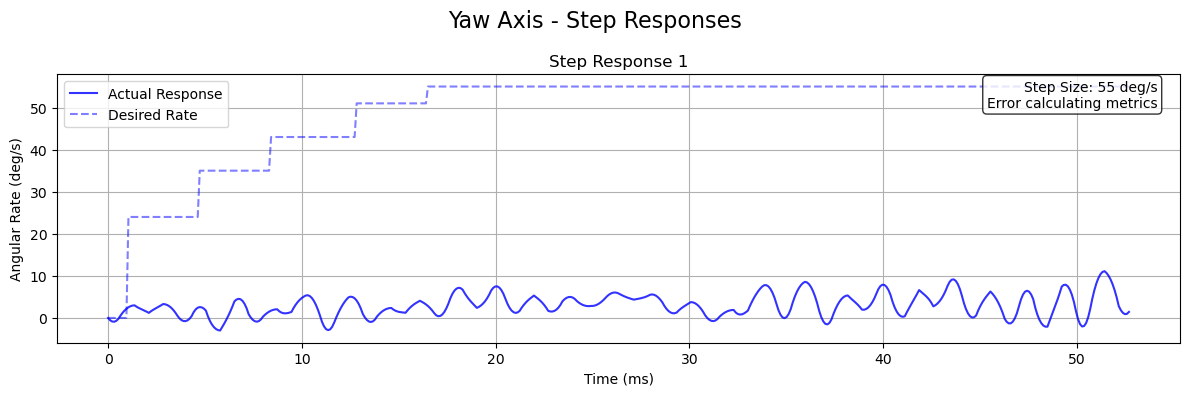

In [48]:

# Read and process the data
file_dir = os.getcwd() + '/Acro'
df = pd.read_csv(file_dir + '/Acro_only_rates.csv')

# Calculate logging rate (assuming timestamp is in milliseconds)
log_rate = 1e9 / np.mean(np.diff(df['timestamp']))
print(f"Calculated logging rate: {log_rate:.1f} Hz")

# Analyze each axis
axes = [
    ('Roll', 'Rate_des_Roll', 'Rate_est_Roll'),
    ('Pitch', 'Rate_des_Pitch', 'Rate_est_Pitch'),
    ('Yaw', 'Rate_des_Yaw', 'Rate_est_Yaw')
]

min_input = 20  # deg/s
num_responses = 1  # Number of step responses to analyze

for axis_name, des_col, est_col in axes:
    print(f"\nAnalyzing {axis_name} axis...")
    
    # Get step responses
    step_responses, setpoint_steps, t = analyze_step_response(
        sp=df[des_col],
        gy=df[est_col],
        log_rate=log_rate,
        smooth_factor=2,  # Medium smoothing
        min_input=min_input
    )
    
    # Plot results with specified number of responses
    plot_step_responses(step_responses, setpoint_steps, t, axis_name, num_responses)